
1 Failed download:
['AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


⚠️ Could not get data from Yahoo Finance. Using synthetic data instead.
Head of original data:
                  Open
2010-01-01  100.010434
2010-01-04  100.008169
2010-01-05  100.021623
2010-01-06  100.052583
2010-01-07  100.048400
Shape: (3391, 1)
x_train shape: (2653, 60, 1)
y_train shape: (2653,)


Training model...

2653/2653 [==============================] - 26s 9ms/step - loss: 0.0035
x_test shape: (678, 60, 1)
y_test shape: (678, 1)
22/22 [==============================] - 1s 6ms/step
Root Mean Squared Error: 0.2584
Mean Absolute Error: 0.2565


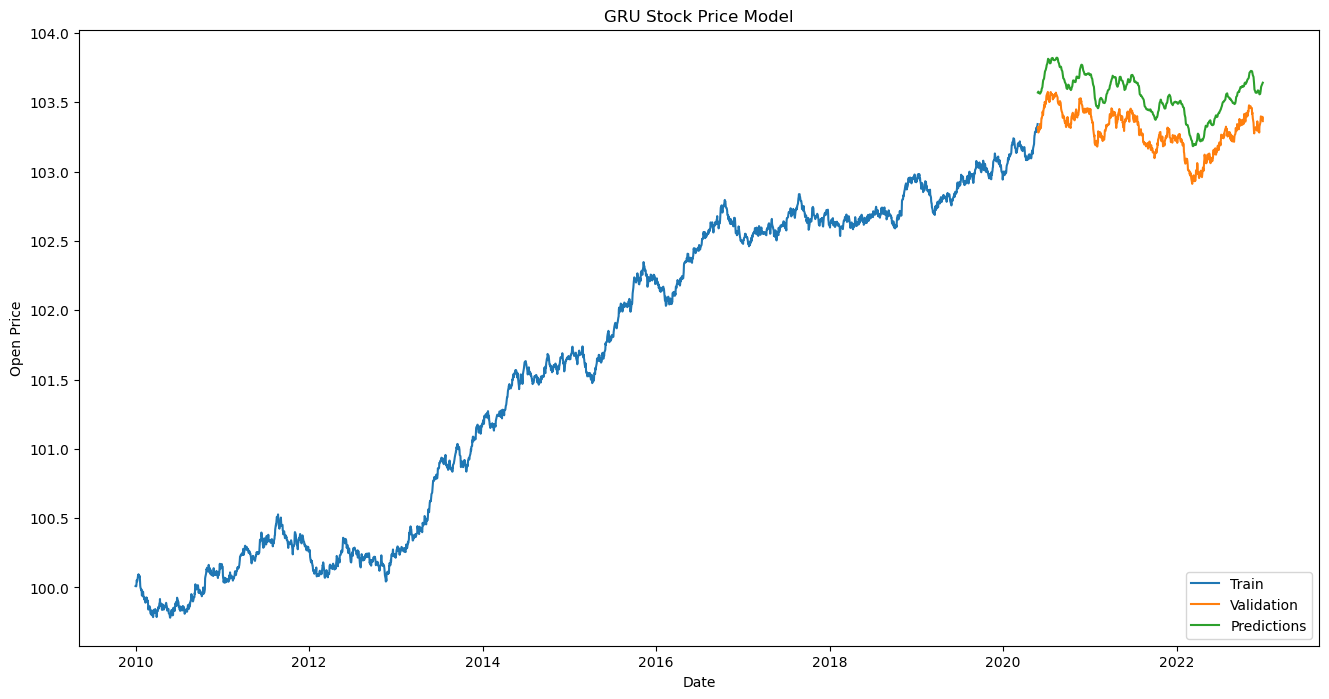

Last few actual vs predicted prices:
                  Open  Predictions
2022-12-26  103.372493   103.624725
2022-12-27  103.374556   103.629997
2022-12-28  103.392288   103.632401
2022-12-29  103.395569   103.636833
2022-12-30  103.364530   103.641769


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

import yfinance as yf

# ----------------------------
# 1. Fetch or simulate data
# ----------------------------

def fetch_stock_data(ticker, start_date, end_date):
    """
    Try to download stock data using yfinance.
    If it fails or returns empty, create synthetic stock-like data.
    """
    try:
        data = yf.download(ticker, start=start_date, end=end_date, progress=False, threads=False)
    except Exception as e:
        print("Error while downloading from yfinance:", e)
        data = pd.DataFrame()

    if data is None or data.empty:
        print("⚠️ Could not get data from Yahoo Finance. Using synthetic data instead.")
        # Create synthetic date index
        dates = pd.date_range(start=start_date, end=end_date, freq='B')  # business days
        np.random.seed(42)
        # Random walk around 100
        returns = np.random.normal(loc=0.0005, scale=0.02, size=len(dates))
        prices = 100 + np.cumsum(returns)
        data = pd.DataFrame({'Open': prices}, index=dates)
    else:
        print("✅ Successfully downloaded data from Yahoo Finance.")

    return data

# ----------------------------
# 2. Load data
# ----------------------------

ticker = 'AAPL'
data = fetch_stock_data(ticker, start_date='2010-01-01', end_date='2023-01-01')

print("Head of original data:")
print(data.head())
print("Shape:", data.shape)

# If data came from yfinance, it has many columns; if synthetic, already only 'Open'
if 'Open' not in data.columns:
    raise ValueError("No 'Open' column found in data.")

# Ensure index is sorted by date
data = data.sort_index()

# Keep only 'Open' prices
data = data[['Open']]

# ----------------------------
# 3. Prepare data for GRU
# ----------------------------

dataset = data.values  # numpy array of shape (N, 1)

training_data_len = int(np.ceil(len(dataset) * 0.8))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create training set (first 80%)
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

lookback = 60  # use past 60 days to predict next day

for i in range(lookback, len(train_data)):
    x_train.append(train_data[i-lookback:i, 0])  # previous 60 values
    y_train.append(train_data[i, 0])             # next value

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape to (samples, timesteps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# ----------------------------
# 4. Build GRU model
# ----------------------------

model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

print("Training model...")
model.fit(x_train, y_train, batch_size=1, epochs=1)

# ----------------------------
# 5. Create test data
# ----------------------------

test_data = scaled_data[training_data_len - lookback:, :]  # include last 60 of train

x_test = []
y_test = dataset[training_data_len:, :]  # true prices (unscaled)

for i in range(lookback, len(test_data)):
    x_test.append(test_data[i-lookback:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# ----------------------------
# 6. Make predictions
# ----------------------------

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# ----------------------------
# 7. Evaluate model
# ----------------------------

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')

# ----------------------------
# 8. Plot results
# ----------------------------

train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('GRU Stock Price Model')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.plot(train['Open'], label='Train')
plt.plot(valid['Open'], label='Validation')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()

print("Last few actual vs predicted prices:")
print(valid.tail())
